# SPA - J = 0 to 1
Simulating the SPA1, i.e. transferring molecules from J = 0 to J = 0 using microwave driven adiabatic passage.

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

from itertools import product
from pathlib import Path
import random
import string
import time


from joblib import Parallel, delayed
import matplotlib.pyplot as plt
# plt.style.use(["seaborn-dark"])
# plt.rcParams["axes.labelsize"] = 20
# plt.rcParams["axes.titlesize"] = 24
# plt.rcParams["xtick.labelsize"] = 18
# plt.rcParams["ytick.labelsize"] = 18
# plt.rcParams["legend.fontsize"] = 20
# plt.rcParams['legend.title_fontsize'] = 20
# plt.rcParams["font.family"] = 'serif'

plt.style.use(['seaborn-deep'])
plt.rcParams["figure.figsize"] = (16, 9)
# plt.style.use(['fivethirtyeight'])
# Font for labels
plt.rcParams['font.family'] = 'serif'
# Linewidths for plots
plt.rcParams['lines.linewidth'] = 1.6
plt.rcParams['lines.marker'] = ''
# Axes
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
# Ticks
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Legend
plt.rcParams['legend.fontsize'] = 16

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import seaborn as sns

import centrex_TlF
from centrex_TlF import UncoupledBasisState
from centrex_TlF.transitions import calculate_transition_frequency
from state_prep.electric_fields import ElectricField, E_field_ring, Ez_from_csv
from state_prep.hamiltonians import SlowHamiltonian, SlowHamiltonianOld
from state_prep.intensity_profiles import GaussianBeam, MeasuredBeam, BackgroundField
from state_prep.magnetic_fields import MagneticField
from state_prep.microwaves import Polarization, Intensity, MicrowaveField
from state_prep.plotters import CouplingPlotter
from state_prep.simulator import Simulator
from state_prep.trajectory import Trajectory
from state_prep.utils import vector_to_state

## Define molecule trajectory
Defining the molecule trajectory as a Trajectory object. Specifying the initial position as z = 50 mm, i.e. 50mm  after the center of the microwaves is, and on the axis of the beamline. Taking the beam velocity to be 200 m/s in the z-direction. The simulation ends when `zfin` is reached, 200 mm from the microwwaves.

In [2]:
trajectory = Trajectory(Rini = np.array((0,0,-80e-3)), Vini = np.array((0,0,200.)), zfin = 200e-3)

## Define electric field
Defining an electric field that is an approximation of what the molecules should see in the real experiment.

In [3]:
# #Define positions for centers of ring electrodes (in m)
# electrode_offset = 0.0
# z1 = -85.725e-3  + electrode_offset
# z2 = 85.725e-3 + electrode_offset

# #Define voltages on the rings
# V1 = 5e3*172/155
# V2 = V1*0.07

# #Define a quickly decaying function to simulate adding shielding between state prep region and detection region
# decay_function = lambda R, Z0, l: np.exp(-0.5*((R[2]-Z0)*float(R[2]>Z0)/l)**2)
# decay_tanh = lambda R,Z0,l,z_shield: .5*(1-np.tanh((R[2]-Z0)/l))

# #Define electric field as function of position
# z_shield = 0.085
# l_decay = 0.02
# z0 = 116.4/1e3

# E_R = lambda R: ((E_field_ring(R, z0 = z1, V = V1)
#                         + E_field_ring(R, z0 = z2, V = V2))*decay_tanh(R,z0,l_decay,z_shield))


# Define electric field based on finite element simulations
Ez = Ez_from_csv()
E_R = lambda R: np.array([0,0,Ez(R[2])])


electric_field = ElectricField(E_R, trajectory.R_t)

Max electric field: 263.46 V/cm
Electric field at z = 1.125'': 109.24 V/cm


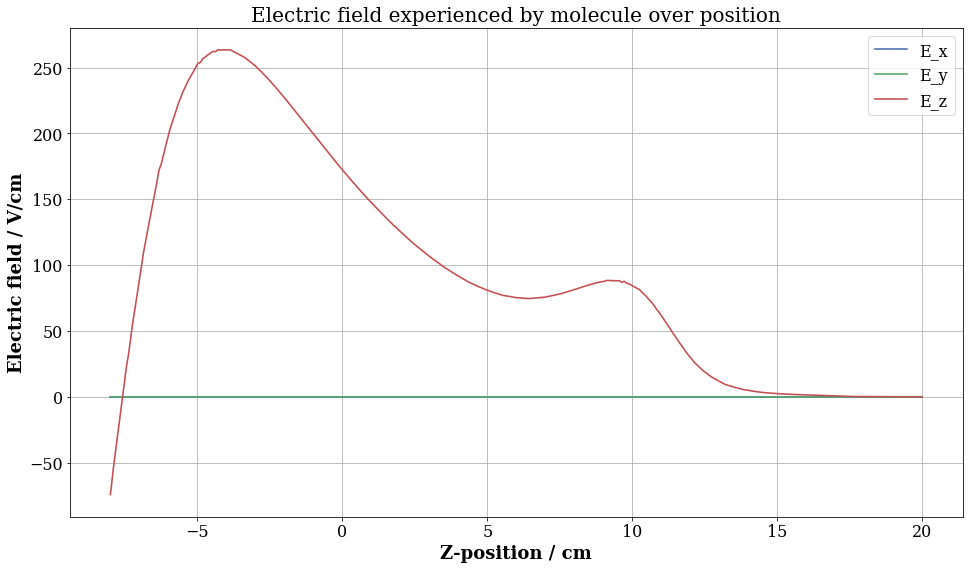

In [4]:
# Plot the electric field as a check:
ts, Es, ax = electric_field.plot(trajectory, position = True)

print(f"Max electric field: {np.max(Es):.2f} V/cm")
print(f"Electric field at z = 1.125'': {E_R(np.array([0,0,0.0254*1.125]))[2]:.2f} V/cm")

## Define magnetic field
Define the magnetic field. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [5]:
B = np.array((0,0,1e-3))
# B = np.array((0.2,0.45,0.1))
def B_R(R):
    if len(R.shape) == 1:
        return B
    else:
        return B.reshape((3,1)) * np.ones(R.shape)

magnetic_field = MagneticField(B_R, R_t = trajectory.R_t)

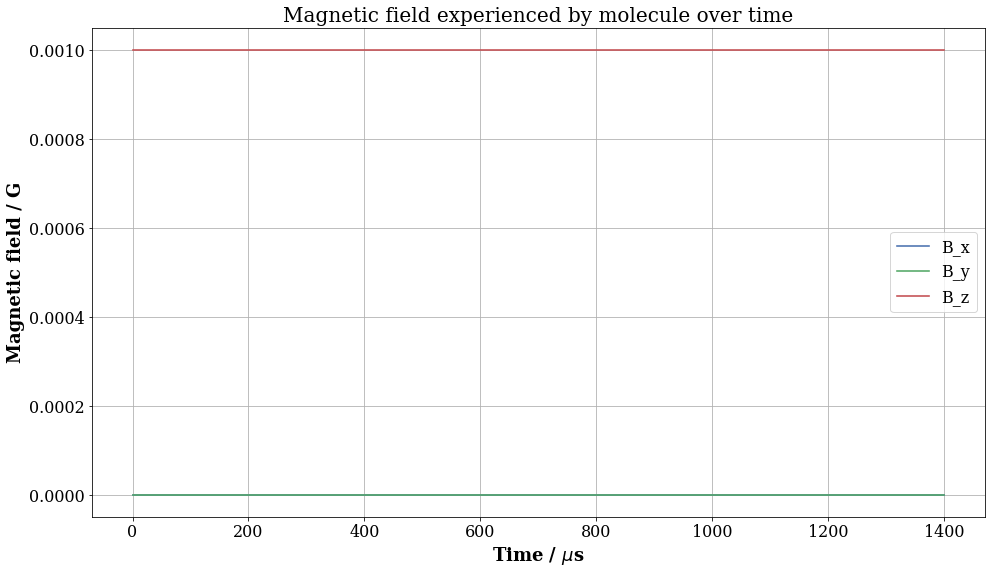

In [6]:
magnetic_field.plot(trajectory)

## Initial and final states
Define approximate initial states here.

In [7]:
#Define some useful approximate states
J0_singlet = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')
                                       -1* UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X'))

J0_triplet_0 = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')
                            +1* UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X'))

J0_triplet_p = 1*UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X')

J0_triplet_m = 1*UncoupledBasisState(J = 0, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')

initial_states_approx = [J0_singlet, J0_triplet_m, J0_triplet_0, J0_triplet_p]

In [8]:
#Define some useful approximate states
J1_singlet = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')
                                       -1* UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

J1_triplet_0 = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')
                            +1* UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

J1_triplet_p = 1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X')

J1_triplet_m = 1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')

# initial_states_approx = [J1_singlet, J1_triplet_m, J1_triplet_0, J1_triplet_p]

In [9]:
#Define some useful approximate states
J2_singlet = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = 1, Omega = 0, electronic_state='X')
                                       -1* UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = 1, Omega = 0, electronic_state='X'))

J2_triplet_0 = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = 1, Omega = 0, electronic_state='X')
                            +1* UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = 1, Omega = 0, electronic_state='X'))

J2_triplet_p = 1*UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = 1, Omega = 0, electronic_state='X')

J2_triplet_m = 1*UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2, P = 1, Omega = 0, electronic_state='X')

final_states_approx = [J2_singlet, J2_triplet_m, J2_triplet_0, J2_triplet_p]

## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 0 and 1 states; J = 0 and 3 are absolutely required since the electric field couples J = 0 to these, J = 3 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [10]:
Js = [0,1,2,3]
hamiltonian = SlowHamiltonian(Js, trajectory, electric_field, magnetic_field)
# hamiltonian = SlowHamiltonianOld(0, 3, trajectory, electric_field, magnetic_field, '../hamiltonians/TlF_X_state_hamiltonian0to3_2020_03_03.pickle')

## Define microwave Hamiltonian
We will define a microwave field with the following properties
- A Gaussian spatial profile with 1'' intensity FWHM (cylindrically symmetric) 
- propagating along the X-direction
- polarized along the Z-direction
- Calculate power based on the desired Rabi rate for the desired transition

### J = 0 to 1 microwaves

In [11]:
# Define states
state1 = J0_singlet
state2 = J1_singlet

# Center position
R0 = np.array((0.00,0,-0.0))

#### Polarization:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])

# Define a function that gives the main component of the polarization as a function of position
p_main = p_z + 0.0 * p_y
P_R = lambda R: p_main/np.sqrt(np.sum(p_main**2))

# Define k-vector
k = np.array((1,0,0))
pol = Polarization(P_R, k, f_long = 1)

#### Frequency
#Calculate the microwave frequency between specified states at a specific point
muW_freq_1 = calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)+2e6
print(f"Transition frequency at center of SPA1 microwaves: {muW_freq_1/1e9:.5f} GHz")

#### Intensity profile:
# Define a Gaussian intensity profile
# intensity = MeasuredBeam(power = 1e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq)
intensity = GaussianBeam(power = 0.5e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq_1)

#### Define MicrowaveField
mf01 = MicrowaveField(0, 1, intensity, pol, muW_freq_1, hamiltonian.QN) 

Transition frequency at center of SPA1 microwaves: 13.34205 GHz


### J = 0 to 1 background field
Defining a field that has uniform intensity everywhere to represent microwaves randomly scattering of the vacuum chamber, windows etc

In [12]:
#### Polarization:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])

# Define a function that gives the main component of the polarization as a function of position
p = p_z + 0.4 *p_y
P_R = lambda R: p/np.sqrt(np.sum(p**2))


pol_bg = Polarization(P_R)

#### Intensity profile:

# Define a Gaussian intensity profile
lims = [(-1,1),(-1,1),(-1,1),]
intensity_bg = BackgroundField(lims, intensity=mf01.intensity.I_R(R0)/70)

#### Define MicrowaveField

mf01_bg = MicrowaveField(0, 1, intensity_bg, pol_bg, muW_freq_1, hamiltonian.QN, background_field=True) 

### J = 1 to 2 microwaves

In [13]:
# Define states
state1 = J1_singlet
state2 = J2_singlet

# Center position
R0 = np.array((0.00,0,0.0254*1.125))

#### Polarization:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])

# Define a function that gives the main component of the polarization as a function of position
p_main = p_z + 0.2 * p_y
P_R = lambda R: p_main/np.sqrt(np.sum(p_main**2))

# Define k-vector
k = np.array((1,0,0))
pol = Polarization(P_R, k, f_long = 1)

#### Frequency
#Calculate the microwave frequency between specified states at a specific point
muW_freq_2 = calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)
print(f"Transition frequency at center of SPA2 microwaves: {muW_freq_2/1e9:.5f} GHz")

#### Intensity profile:
# Define a Gaussian intensity profile
# intensity = MeasuredBeam(power = 1e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq)
intensity = GaussianBeam(power = 0.5e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq_2)

#### Define MicrowaveField
mf12 = MicrowaveField(1, 2, intensity, pol, muW_freq_2, hamiltonian.QN)

Transition frequency at center of SPA2 microwaves: 26.66877 GHz


### J = 1 to 2 background field
Defining a field that has uniform intensity everywhere to represent microwaves randomly scattering of the vacuum chamber, windows etc

In [14]:
#### Polarization:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])

# Define a function that gives the main component of the polarization as a function of position
p = p_z + 0.4 *p_y
P_R = lambda R: p/np.sqrt(np.sum(p**2))


pol_bg = Polarization(P_R)

#### Intensity profile:
# Define a Gaussian intensity profile
lims = [(-1,1),(-1,1),(-1,1),]
intensity_bg = BackgroundField(lims, intensity=mf01.intensity.I_R(R0)/100)

#### Define MicrowaveField
mf12_bg = MicrowaveField(1, 2, intensity_bg, pol_bg, muW_freq_2, hamiltonian.QN, background_field=True) 

### Define list of microwave fields

In [15]:
microwave_fields = [mf01, mf01_bg, mf12, mf12_bg]

## Time-evolution
Next define a Simulator and use it to numerically integrate the Schroedinger equation to see how the states evolve as the electric field is ramped down. 

In [16]:
simulator = Simulator(trajectory, electric_field, magnetic_field, initial_states_approx, hamiltonian, microwave_fields)

In [34]:
# Set microwave parameters
## Center postion
R0 = np.array([0.00,0,0.0254*1.125])

## Sigma
mf12.intensity.sigma = 1.0*25.4e-3/(2*np.sqrt(2*np.log(2)))

## Frequency
freq = calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)
detuning = -.4e6
mf12.set_frequency(freq + detuning)
mf12_bg.set_frequency(freq + detuning)
mf12.set_position(R0)

## Power
# mf01.calculate_microwave_power(state1, state2, 2*np.pi*100e3, R0)
mf12.set_power(1e-13)
mf12_bg.intensity.intensity = mf12.intensity.I_R(R0)/70

# Molecule parameters
trajectory.Rini = np.array([0,0.00,-80e-3])
trajectory.Vini = np.array([0,0,184])

In [35]:
result = simulator.run(N_steps = 10000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [06:12<00:00, 26.83it/s]


## Plot results

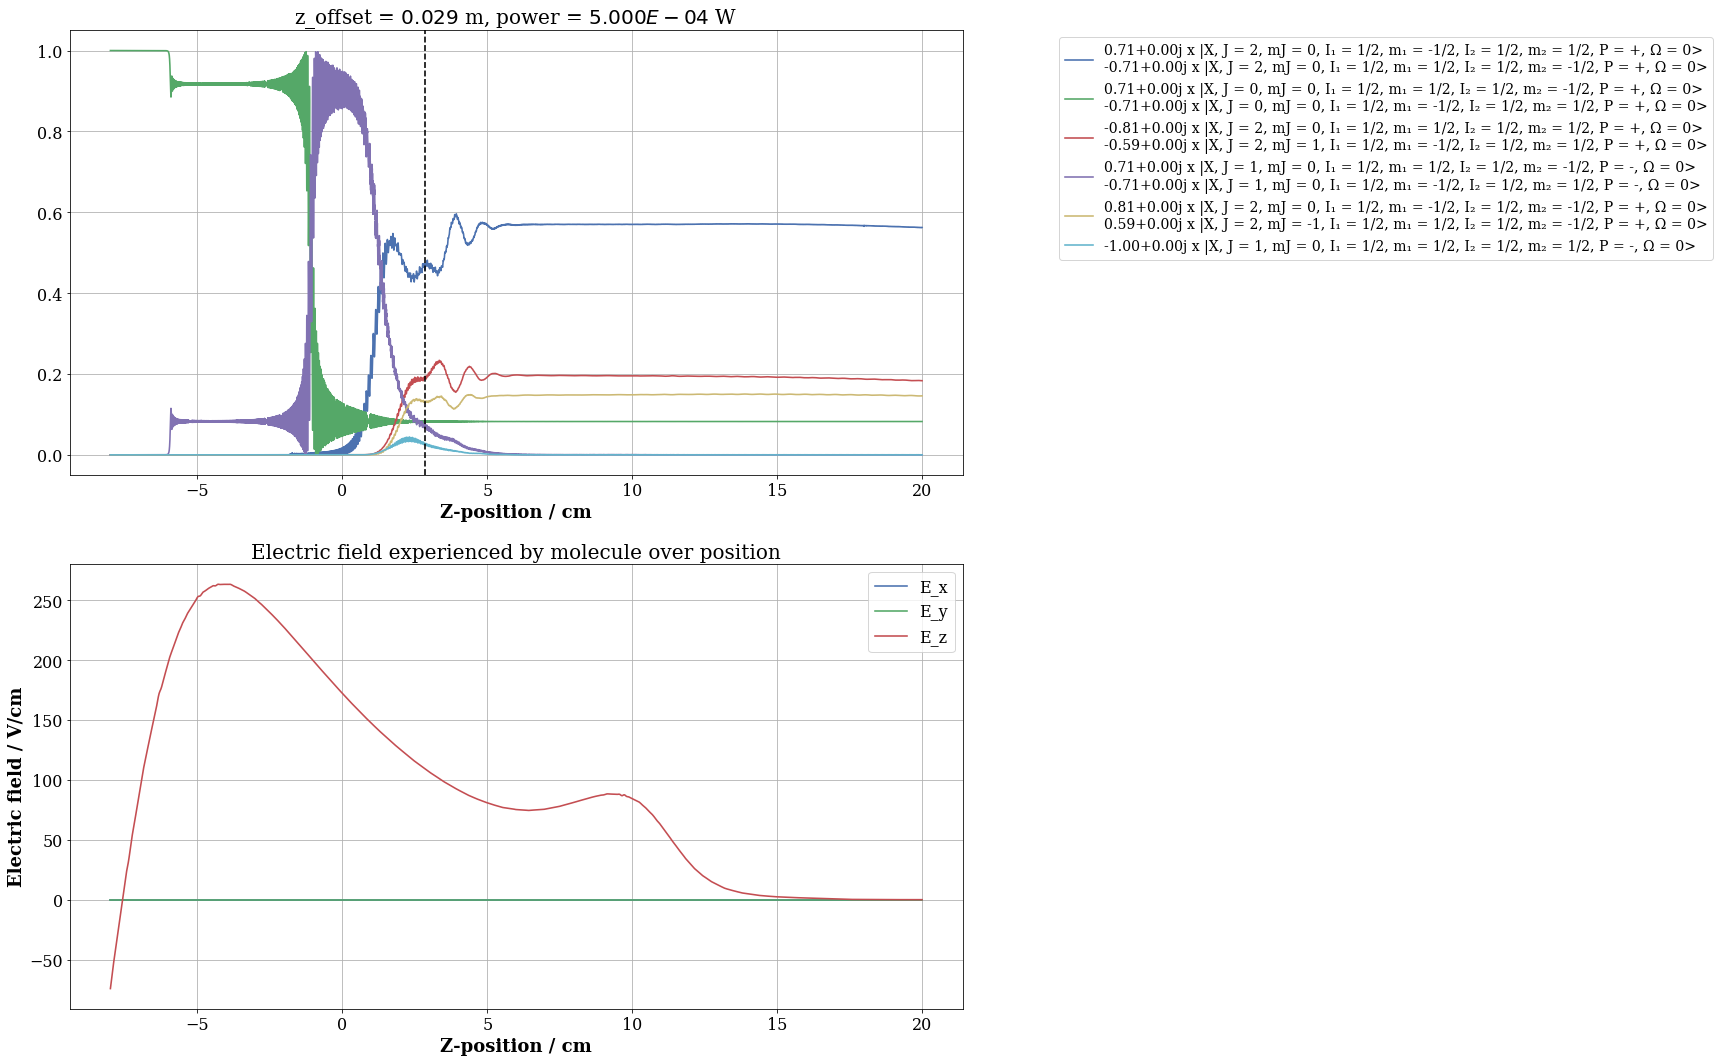

In [55]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N = 6)
fig, (ax, ax2) = plt.subplots(2,1, figsize = (16,18))
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, position = True)
ax.legend(fontsize = 14, bbox_to_anchor = (1.1,1))
ax.axvline(x = R0[2]*1e2, ls ='--', c = 'k')
ax.set_title(f"z_offset = ${R0[2]:.3f}$ m, power = ${mf12.intensity.power:.3E}$ W")

_ = electric_field.plot(trajectory, position=True, ax = ax2)

### Plot intensity profile
Check that the longitudinal polarization appears correctly

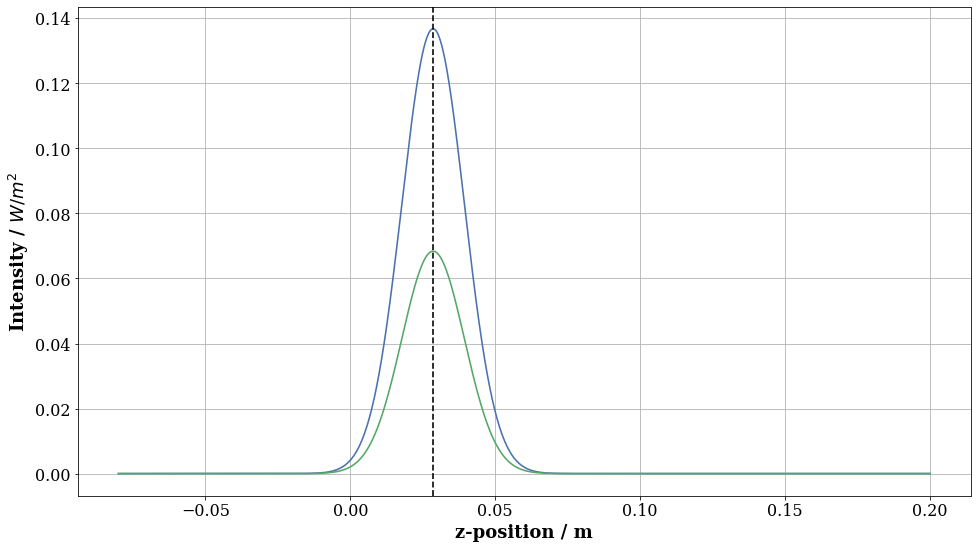

In [20]:
t_array = np.linspace(0, trajectory.get_T(), 1000)
Rs = np.array([trajectory.R_t(t) for t in t_array])
intensities_R = np.array([mf12.intensity.I_R(trajectory.R_t(t)) for t in t_array])
intensities = np.array([mf12.intensity.I_R(np.array([0.0,0.0127,z])) for z in Rs[:,2]])

fig, ax = plt.subplots()
ax.plot(Rs[:,2],intensities_R)
ax.plot(Rs[:,2],intensities)
ax.set_xlabel("z-position / m")
ax.set_ylabel(r"Intensity / $W/m^2$")
ax.axvline(x = R0[2], ls ='--', c = 'k')

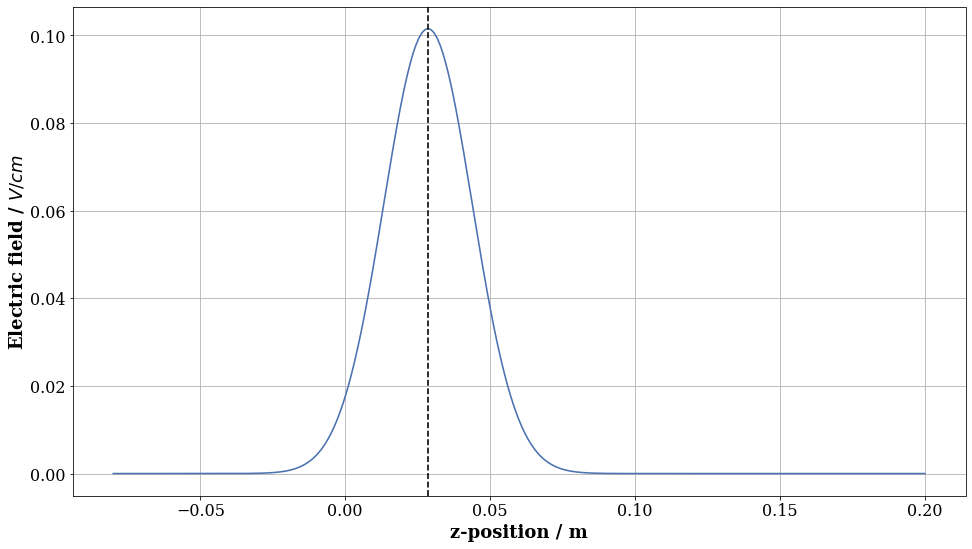

In [21]:
E_mags_R = np.array([mf12.intensity.E_R(trajectory.R_t(t)) for t in t_array])
E_mags = np.array([mf12.intensity.E_R(np.array((0.,0.0,z))) for z in Rs[:,2]])

fig, ax = plt.subplots()
ax.plot(Rs[:,2], E_mags_R)
# ax.plot(Rs[:,2], E_mags)
ax.set_xlabel("z-position / m")
ax.set_ylabel(r"Electric field / $V/cm$")
ax.axvline(x = R0[2], ls ='--', c = 'k')

### Plot polarization components as function of position
Check that the longitudinal polarization appears correctly

C:\Users\Oskari\Anaconda3\envs\state_prep\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


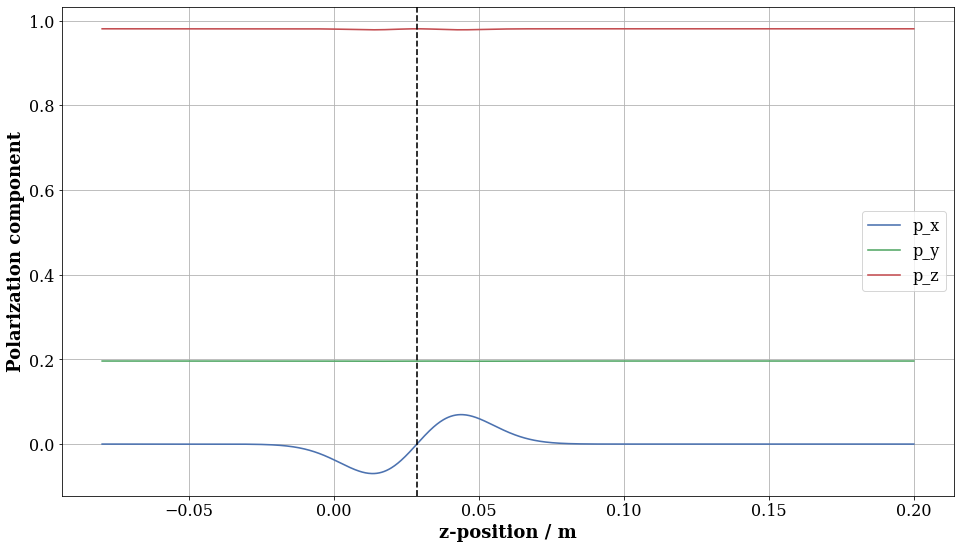

In [22]:
pols = np.array([mf12.polarization.p_R(trajectory.R_t(t), mf12.intensity, freq=muW_freq_2) for t in t_array])

fig, ax = plt.subplots()
ax.plot(Rs[:,2], np.imag(pols[:,0]), label='p_x')
ax.plot(Rs[:,2], pols[:,1], label='p_y')
ax.plot(Rs[:,2], np.real(pols[:,2]), label='p_z')
ax.legend()
ax.set_xlabel("z-position / m")
ax.set_ylabel("Polarization component")
ax.axvline(x = R0[2], ls ='--', c = 'k')

## Parameter scans
### Helper functions
Define two helper function to run the power scans:

In [64]:
def run_simulation(power: float, detuning: float, R0: np.ndarray, Rini:np.ndarray, Vini: np.ndarray, J1_state: centrex_TlF.State, target_state: centrex_TlF.State, save_path: Path = None, N_steps = 10000):
    """
    Runs the simulation for one value of power and finds the probability of ending up in the target state.
    """
    # Run simulator for just SPA1 so can normalize for its efficiency
    # Set power to 0
    mf12.set_power(1e-12)
    mf12_bg.intensity.intensity = mf12.intensity.I_R(R0)/70*1
    resultSPA1 = simulator.run(N_steps = N_steps)

    
    # Run simulation that includes SPA2
    ## Microwave settings    
    # Set position
    mf12.set_position(R0)
    
    # Set frequency
    freq = calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)
    mf12.set_frequency(freq + detuning)
    mf12_bg.set_frequency(freq + detuning)
    mf12.set_position(R0)

    # Set power
    mf12.set_power(power)
    mf12_bg.intensity.intensity = mf12.intensity.I_R(R0)/70*1
    
    # Trajectory settings
    trajectory.Rini = Rini
    trajectory.Vini = Vini
    
    # Run the simulator
    result = simulator.run(N_steps = N_steps)
    
    # Save result if save path provided
    if save_path:
        result.save_to_pickle(save_path)
        
    # Determine probability to be in initial state
    prob_J0 = result.get_state_probability(result.initial_states[0], initial_state = result.initial_states[0])[-1]
    
    # Determine probability to be in initial state after SPA1
    prob_J1_ini = resultSPA1.get_state_probability(J1_state, initial_state = resultSPA1.initial_states[0])[-1]
    
    # Determine probability to be in initial state
    prob_J1 = result.get_state_probability(J1_state, initial_state = result.initial_states[0])[-1]

    # Determine probability to be in target state
    prob_fin = result.get_state_probability(target_state, initial_state = result.initial_states[0])[-1]
    
    # Return a dataframe
    df = pd.DataFrame({"power":[power], "detuning":[detuning], "muw_position": [R0], "Rini":[Rini], "Vini":[Vini],"prob_J0":[prob_J0], "prob_J1_ini":[prob_J1_ini], "prob_J1":[prob_J1], "prob_fin": [prob_fin], "save_path": [save_path]})
    
    return df

In [65]:
# Define the function to be run in parallel
def parallel_func(power = 10**(-4.1), detuning = 0, R0 = np.array([0.00,0,0.0254*1.125]), Rini = np.array((0,0,-80e-3)), Vini = np.array((0,0,184.)), save = False, N_steps = 10000):
    save_path = SAVE_DIR / Path(f"result_{generate_random_key()}") if save else None
    return run_simulation(power, detuning, R0, Rini, Vini, J1_singlet, J2_singlet, save_path=save_path, N_steps = N_steps)

In [66]:
# Function for generating random keys for the results
def generate_random_key(length: int = 6):
    return ''.join(random.choices(string.ascii_letters + string.digits, k = length))

In [67]:
run_simulation(mf01.intensity.power, 0, np.array([0.00,0,0.0254*1.125]), trajectory.Rini, trajectory.Vini, J1_singlet, J2_singlet, N_steps = 10000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:42<00:00, 234.83it/s]


,power,detuning,muw_position,Rini,Vini,prob_J0,prob_J1_ini,prob_J1,prob_fin,save_path
0,0.0005,0,"[0.0, 0.0, 0.028575]","[0.0, 0.0, -0.08]","[0, 0, 184]",0.082446,0.916045,0.000412,0.898869,None


### Save directory

In [68]:
SAVE_DIR = Path('../../../results/SPA2 - parameter scans')

### Power values

In [29]:
powers = 10**((np.linspace(-70,10,36)-30)/10) # in W

### Run power scan

In [30]:
# Initialize parallel loop
df = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=power, detuning = -0.4e6,) for power in powers)).reset_index(drop=True)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  36 out of  36 | elapsed:  3.7min finished


Text(0, 0.5, 'Populations in each state')

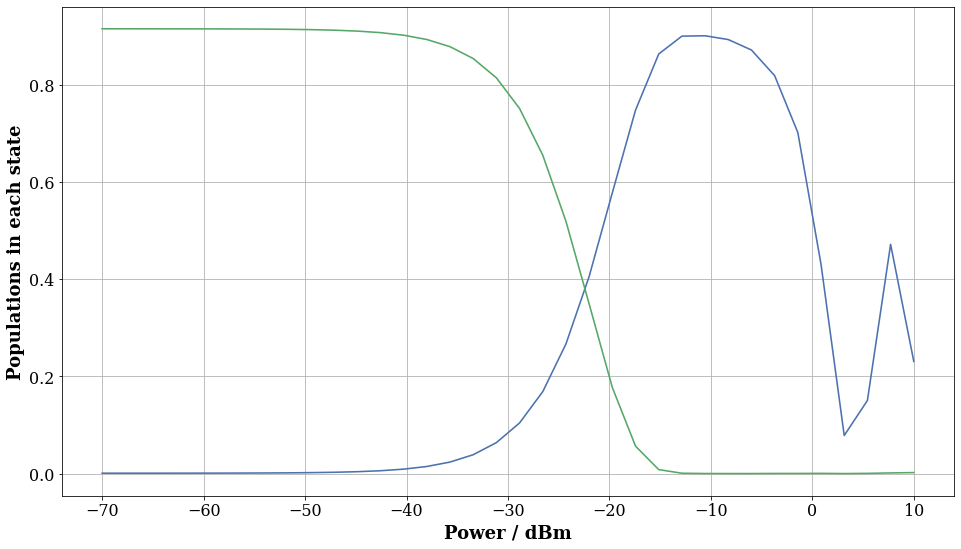

In [45]:
fig, ax = plt.subplots()
ax.plot(10*np.log10(df.power)+30, df.prob_fin)
ax.plot(10*np.log10(df.power)+30, df.prob_J1)
ax.set_xlabel("Power / dBm")
ax.set_ylabel("Populations in each state")

### Run frequency scan

In [69]:
# Define detunings
deltas = np.linspace(-2, 2, 41)*1e6 # in Hz

In [70]:
# run simulations for different parameters
df_freq = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=5e-5, detuning=delta, N_steps=10000) for delta in deltas)).reset_index(drop=True)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  41 out of  41 | elapsed:  8.3min finished


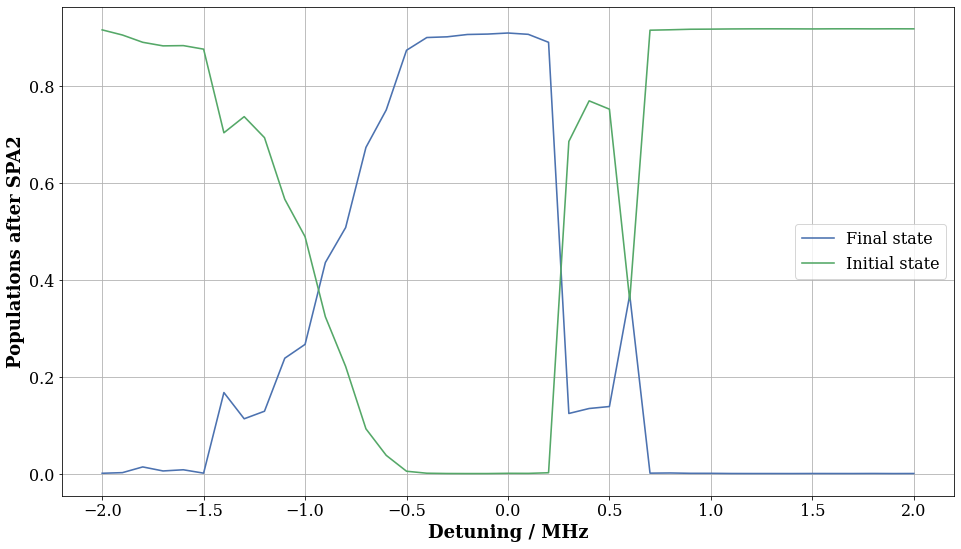

In [71]:
fig, ax = plt.subplots()
ax.plot(df_freq.detuning/1e6, df_freq.prob_fin, label = 'Final state')
ax.plot(df_freq.detuning/1e6, df_freq.prob_J1, label = 'Initial state')
ax.set_xlabel("Detuning / MHz")
ax.set_ylabel("Populations after SPA2")
ax.grid(True)
ax.legend()

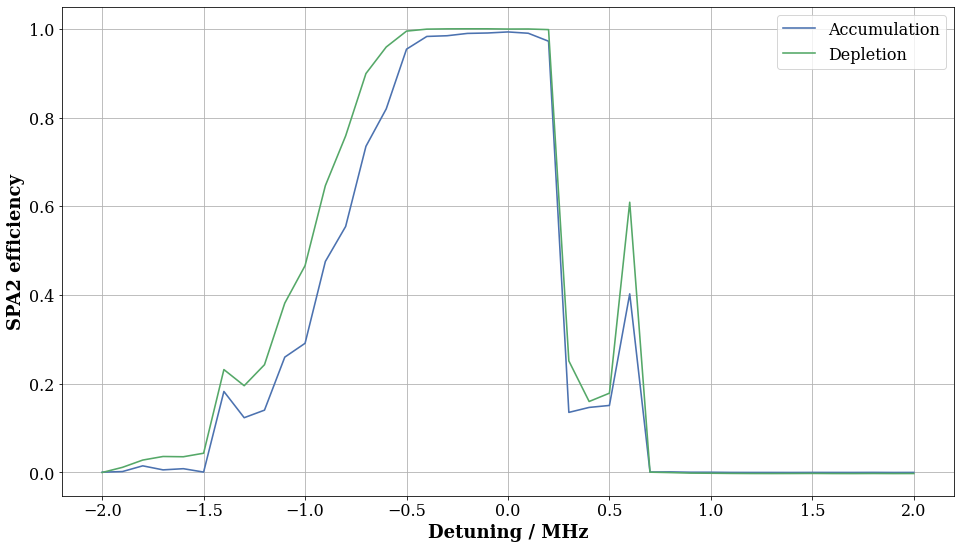

In [74]:
# Calculate efficiency of SPA2 while normalizing for efficiency of SPA1
df_freq['SPA2_eff_dep'] = (1 - df_freq.prob_J1/df_freq.prob_J1_ini)
df_freq['SPA2_eff_acc'] = df_freq.prob_fin/df_freq.prob_J1_ini

fig, ax = plt.subplots()
ax.plot(df_freq.detuning/1e6, df_freq.SPA2_eff_acc, label = 'Accumulation')
ax.plot(df_freq.detuning/1e6, df_freq.SPA2_eff_dep, label = 'Depletion')
ax.set_xlabel("Detuning / MHz")
ax.set_ylabel("SPA2 efficiency")
ax.grid(True)
ax.legend()

In [28]:
# df_freq.to_csv(SAVE_DIR / Path('detuning_scan_with_bg_yzpol_at_1e-4W.csv'))

### Frequency scans at different powers

In [41]:
# Define detunings
deltas = np.linspace(-2, 2, 41)*1e6 # in Hz
powers = np.linspace(0.1,2, 10)*1e-4

params = product(powers, deltas)

In [42]:
# run simulations for different parameters
df_freq = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=power, detuning=delta) for power, delta in params)).reset_index(drop=True)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:  3.3min
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed: 17.4min
[Parallel(n_jobs=9)]: Done 410 out of 410 | elapsed: 38.1min finished


In [43]:
df_temp = df_freq.copy()

In [49]:
df_temp.to_csv(SAVE_DIR / Path('detuning_scans_at_different_powers - imperfect SPA1.csv'))

In [37]:
df_temp['detuningMHz'] = df_temp.detuning/1e6
df_temp['powermW'] = df_temp.power*1e3
df_temp['eff_dep'] = 1-df_temp.prob_J1

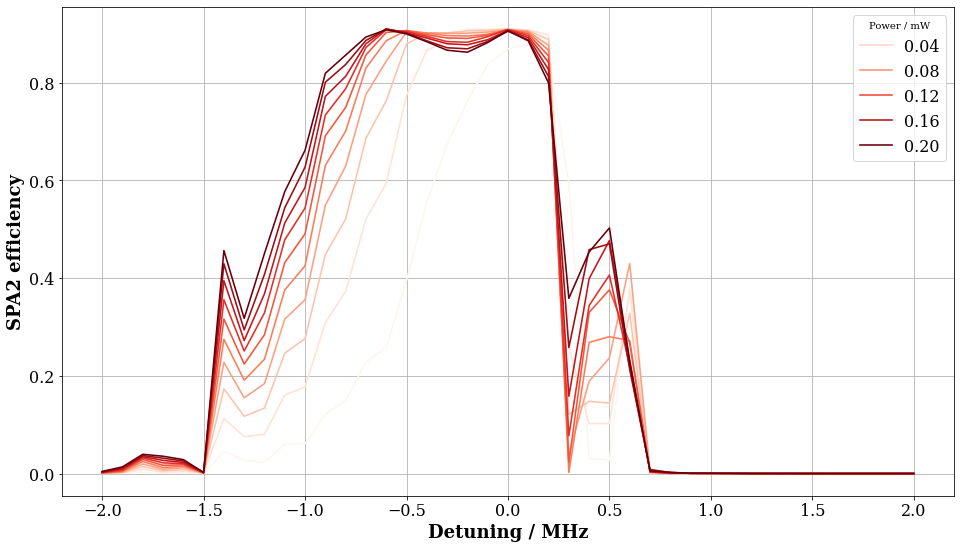

In [38]:
ax = sns.lineplot(data = df_temp, x = 'detuningMHz', y = 'prob_fin', hue = 'powermW', palette='Reds')
# ax = sns.lineplot(data = df_temp, x = 'detuningMHz', y = 'eff_dep', hue = 'powermW', palette='Reds', ax = ax)

ax.set_xlabel("Detuning / MHz")
ax.set_ylabel("SPA2 efficiency")
ax.legend(title = 'Power / mW')
ax.grid(True)

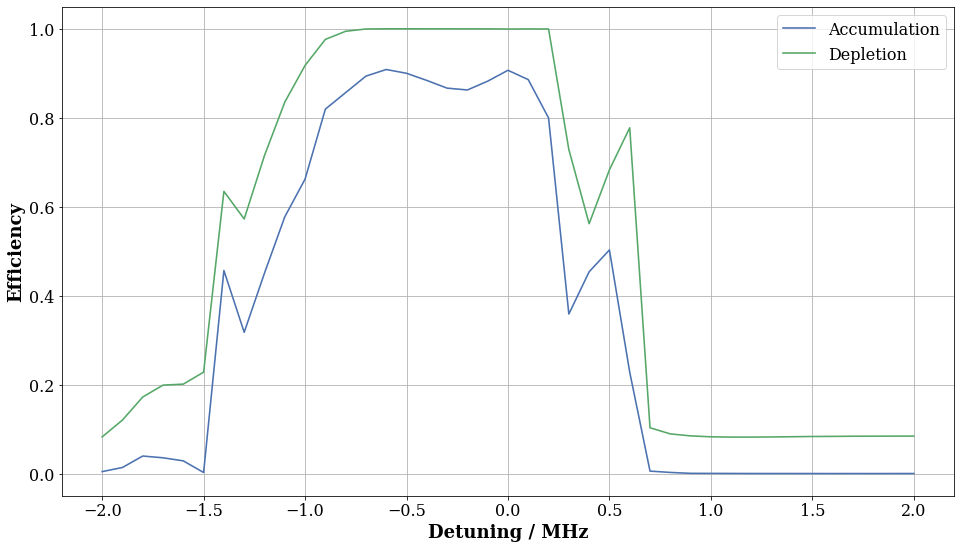

In [40]:
fig, ax = plt.subplots()
power = df_temp.power.unique()[9]
idx = df_temp.power == power
ax.plot(df_temp[idx].detuningMHz, df_temp[idx].prob_fin, label = 'Accumulation')
ax.plot(df_temp[idx].detuningMHz, df_temp[idx].eff_dep, label = 'Depletion')
ax.set_xlabel('Detuning / MHz')
ax.set_ylabel('Efficiency')
ax.legend()

In [36]:
df_temp = pd.read_csv(SAVE_DIR / Path('detuning_scans_at_different_powers - imperfect SPA1.csv'))